# Installation
This notebook requires the following sample jobs to be present in the database. 
```
	 CM4_piControl_C_atmos_level_00050101
	 CM4_piControl_C_atmos_level_00100101
	 CM4_piControl_C_atmos_level_00150101
	 CM4_piControl_C_atmos_level_00200101
	 CM4_piControl_C_atmos_level_00250101
```

If you haven't done so yet, please **epmt submit** those directories to the database of your choice from the shell. See **README.md**:

```
$ cd OutliersData
$ ./extract.sh
$ cd ..
$ ./epmt submit OutliersData/*.dir
```

# Configuration

* Import the needed modules
* Modify any settings

After this runs we have a fully bound database model.

In [239]:
from models import *
from epmt_job import setup_orm_db
import settings
print(settings.db_params)

# Lets use the host 'db'

settings.db_params["host"] = "db"
setup_orm_db(settings)

# Set up graphing and analytics

from matplotlib import rcParams
%matplotlib inline
rcParams['figure.figsize'] = [14, 6]
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd


{'provider': 'postgres', 'user': 'postgres', 'password': 'example', 'host': 'db', 'dbname': 'EPMT'}


# Browse the Database

List jobs in the database that match a **component**. Let's also print their duration and start time.


In [240]:
js = select(j for j in Job if j.ppr.component == "atmos_level")[:]
for j in js:
    print("\t",j.jobname,j.duration/1.0e6,j.start)
print(len(js[:]),"jobs found")


	 CM4_piControl_C_atmos_level_00050101 7618.369066 2019-02-20 19:58:41.714446
	 CM4_piControl_C_atmos_level_00100101 8948.181983 2019-02-21 04:41:56.596528
	 CM4_piControl_C_atmos_level_00150101 8227.289876 2019-02-21 08:22:12.046131
	 CM4_piControl_C_atmos_level_00200101 4826.598722 2019-02-21 15:12:27.619713
	 CM4_piControl_C_atmos_level_00250101 8548.81482 2019-02-22 15:00:09.280291
5 jobs found


# Extract the Data

From the bound DB objects to Python lists and Pandas DataFrames. The following is quite inefficient!

In [241]:
# Turn then into python lists

jobobjs = [j for j in js]
durations = [j.duration for j in js]
names = [j.jobname for j in js]
starts = [j.start for j in js]
numprocs = [len(j.processes) for j in js]

# Turn lists into a Pandas Dataframe, with rows and columns

df = pd.DataFrame({'job_object':jobobjs, 'duration':durations, 'starttime':starts, "numprocs":numprocs})
df

,job_object,duration,starttime,numprocs
0,Job['20345340.moab01.princeton.rdhpcs.noaa.gov'],7.618369e+09,2019-02-20 19:58:41.714446,46237
1,Job['20348694.moab01.princeton.rdhpcs.noaa.gov'],8.948182e+09,2019-02-21 04:41:56.596528,46237
2,Job['20349537.moab01.princeton.rdhpcs.noaa.gov'],8.227290e+09,2019-02-21 08:22:12.046131,46237
3,Job['20352721.moab01.princeton.rdhpcs.noaa.gov'],4.826599e+09,2019-02-21 15:12:27.619713,54166
4,Job['20362929.moab01.princeton.rdhpcs.noaa.gov'],8.548815e+09,2019-02-22 15:00:09.280291,46237


# Find Outliers

## By Job Wallclock Duration or Total Process Count

### Visually

Look at duration and process count of Jobs using a bar chart and a box plot.

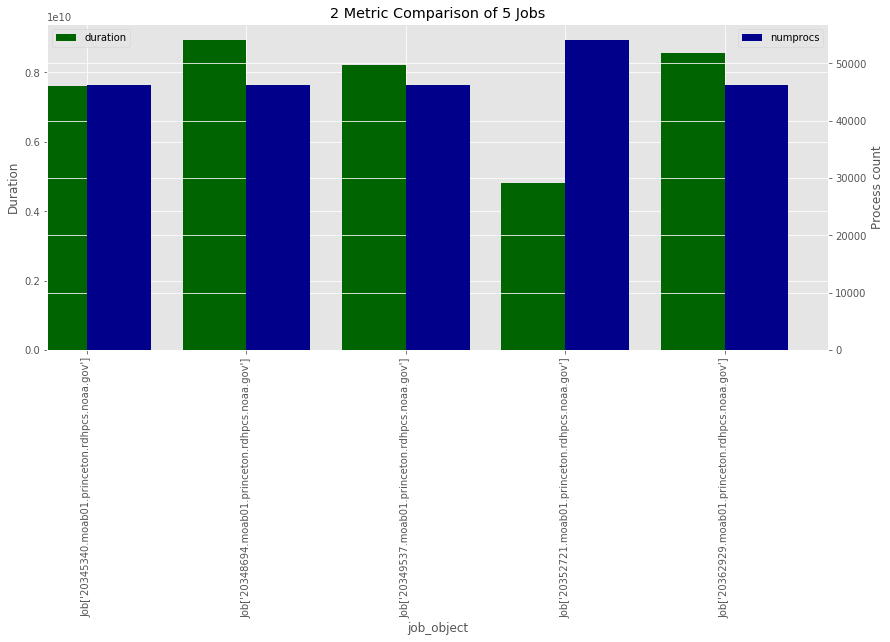

In [334]:
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
ax.set_ylabel('Duration')
ax2.set_ylabel('Process count')
plt.title("2 Metric Comparison of 5 Jobs")
ax.set_xlabel("Job")
width = 0.4
box1 = df.plot.bar(x='job_object', y='duration', color='darkgreen', ax=ax, width=width, position=1)
box2 = df.plot.bar(x='job_object', y='numprocs', color='darkblue', ax=ax2, width=width, position=0)
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='upper left')
patches, labels = ax2.get_legend_handles_labels()
ax2.legend(patches, labels, loc='upper right')

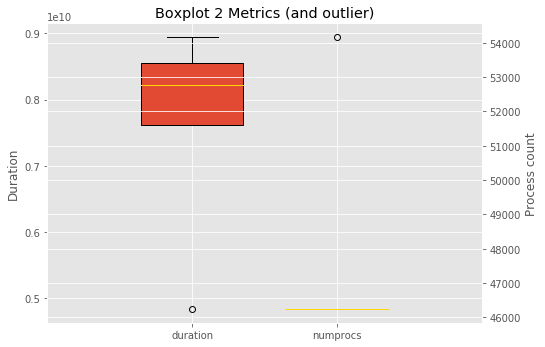

In [335]:
fig, ax1  = plt.subplots(figsize=(7.8, 5.51))
props = dict(widths=0.7,patch_artist=True, medianprops=dict(color="gold"))
box1=ax1.boxplot(df['duration'].values, positions=[0], **props)
ax2 = ax1.twinx()
box2=ax2.boxplot(df['numprocs'].values, positions=[1], **props)
ax1.set_xlim(-1.0,2.0)
ax1.set_xticks(range(2))
ax1.set_xticklabels(['duration','numprocs'])
for b in box1["boxes"]+box2["boxes"]:
    b.set_facecolor(next(ax1._get_lines.prop_cycler)["color"])
ax1.set_ylabel('Duration')
ax2.set_ylabel('Process count')
ax.set_ylabel('Duration')
plt.title("Boxplot 2 Metrics (and outlier)")
plt.show()




## Computationally using IQR

Define helper functions to identify and separate our outliers.

In [336]:
def outliers_z_score(ys):
    threshold = 3
    mean_y = ys.mean()
    stdev_y = ys.std()
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return ys.where(z_scores > threshold)
def outliers_modified_z_score(ys):
    threshold = 3.5
    median_y = ys.median()
    median_absolute_deviation_y = ys.mad()
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in ys]
    return ys.where(np.abs(modified_z_scores) > threshold)
def outliers_iqr(ys):
    quartile_1, quartile_3 = ys.quantile(q=[.25, .75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
#    print(iqr,lower_bound,upper_bound)
    return ys.where((ys < lower_bound) | (ys > upper_bound))
def get_outliers(df,column,func=outliers_iqr):
    outliers = func(df[column])
    odf = df[outliers > 0].reset_index(drop=True)
    gdf = df[outliers.isnull() == True].reset_index(drop=True)
    return(gdf,odf)

# We could look at outliers for any field
good,outliers = get_outliers(df,"numprocs")
print(outliers)

# But lets do duration
good,outliers = get_outliers(df,"duration")
print(outliers)



                                         job_object      duration  \
0  Job['20352721.moab01.princeton.rdhpcs.noaa.gov']  4.826599e+09   

                   starttime  numprocs  
0 2019-02-21 15:12:27.619713     54166  
                                         job_object      duration  \
0  Job['20352721.moab01.princeton.rdhpcs.noaa.gov']  4.826599e+09   

                   starttime  numprocs  
0 2019-02-21 15:12:27.619713     54166  


# Deeper Examination of an Outlier

Let's compare the number and duration of executables present in this job versus the good jobs. First let's fetch all the duration data for all the processes of this job.

## Gathering Process Information

Lets gather up information about the processes in our suspected outlier


In [337]:
j = outliers.job_object[0]
procobjs = [p for p in j.processes]
exenames = [p.exename for p in j.processes]
starts = [p.start for p in j.processes]
durations = [p.duration for p in j.processes]
jobobjs = [p.job for p in j.processes]
odf = pd.DataFrame({'process':procobjs, 'exename':exenames, 'duration':durations, 'start':starts, 'job':jobobjs})
# Put in time order
odf = odf.sort_values("start")
print("outlier:",len(odf),"processes in the following jobs:\n",j)


outlier: 54166 processes in the following jobs:
 Job['20352721.moab01.princeton.rdhpcs.noaa.gov']


And now do the same for our **good** jobs.


In [338]:
procobjs=[]
exenames=[]
starts=[]
durations=[]
jobobjs=[]

for j in good.job_object:
#    print(j)
    for p in j.processes:
        procobjs.append(p)
        exenames.append(p.exename)
        starts.append(p.start)
        durations.append(p.duration)
        jobobjs.append(p.job)

gdf = pd.DataFrame({'process':procobjs, 'exename':exenames, 'duration':durations, 'start':starts, 'job':jobobjs})
# Put in time order
gdf = gdf.sort_values("start")
print("reference:",len(gdf),"processes in the following jobs:\n",good.job_object.to_string(index=False))



reference: 184948 processes in the following jobs:
 Job['20345340.moab01.princeton.rdhpcs.noaa.gov']
Job['20348694.moab01.princeton.rdhpcs.noaa.gov']
Job['20349537.moab01.princeton.rdhpcs.noaa.gov']
Job['20362929.moab01.princeton.rdhpcs.noaa.gov']


## Look at Binaries in Job

### Look at processes by name

Find executables that didn't or should not have run.

In [339]:
g_groupby = gdf.groupby(['exename'])
o_groupby = odf.groupby(['exename'])
for e in g_groupby.groups.keys():
    if e not in o_groupby.groups.keys():
        print("\t",e,"was never executed")
for e in o_groupby.groups.keys():
    if e not in g_groupby.groups.keys():
        print("\t",e,"was unexpectedly executed")

	 TAVG.exe was never executed
	 basename was never executed
	 cp was never executed
	 date was never executed
	 dmget was never executed
	 dmput was never executed
	 du was never executed
	 fregrid was never executed
	 id was never executed
	 list_ncvars.exe was never executed
	 mv was never executed
	 ncatted was never executed
	 ncexists was never executed
	 ncks was never executed
	 ncra was never executed
	 rm was never executed
	 tar was never executed
	 wc was never executed
	 mailx was unexpectedly executed
	 sendmail.postfix was unexpectedly executed


### Look at processes by name vs. mean(duration), mean(count)

Outlier:  Job['20352721.moab01.princeton.rdhpcs.noaa.gov']


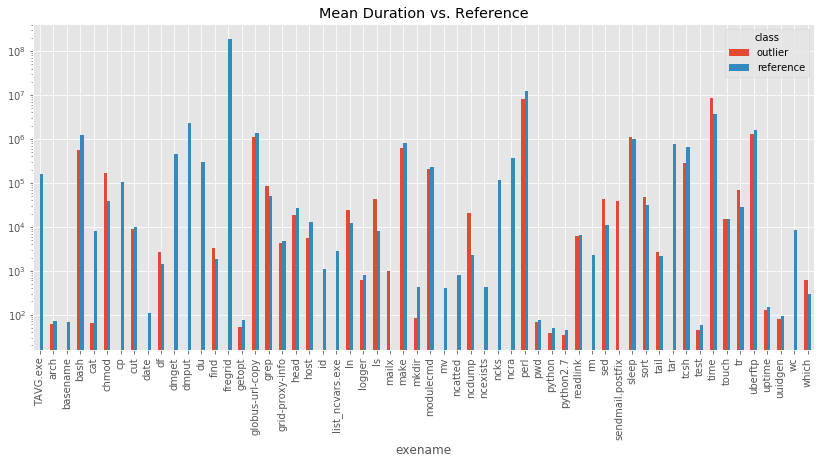

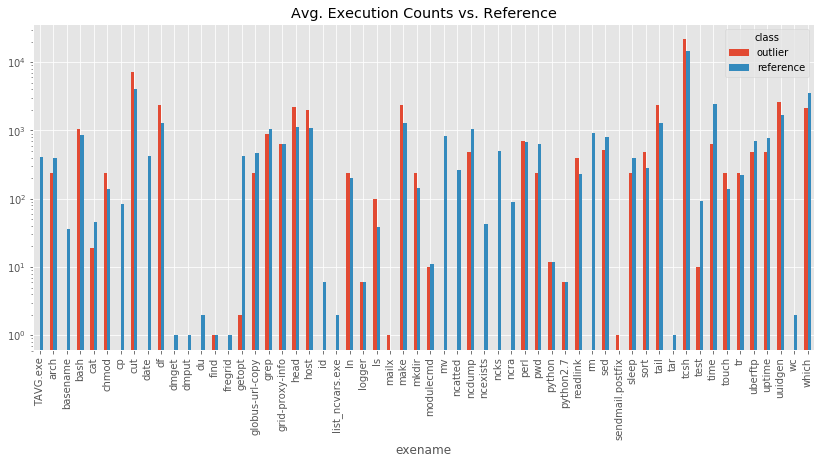

In [340]:
print("Outlier: ",outliers.job_object[0])
# Make a new dataframe with a class column indicating outlier or not
newodf = odf.copy()
newodf["class"] = "outlier"
newgdf = gdf.copy()
newgdf["class"] = "reference"
fulldf = newgdf.append(newodf)

        
# print(fulldf.head())
# print(fulldf.tail())
#
# This mysterious line produces a grouped bar graph (exename on x-axis, class = outlier/ref, duration = height)
#
fulldf.groupby(['exename', 'class'])['duration'].mean().unstack().plot.bar(grid=True)
plt.yscale('log')
plt.title("Mean Duration vs. Reference")
plt.show()

# Surely there must be an easier way with groupby, but I could not figure it out in time. This counts up by job, exe
# avg number of executions and returns 2 lists, exenames and avgcounts.

def get_avg_counts_exes(idf):
    exesinjob = {}
    execnt = {}
    for index, row in idf.iterrows():
        exe = row['exename']
        job = row['job']
        if exe not in exesinjob:
            exesinjob[exe] = [job]
            execnt[exe] = 1
        elif job not in exesinjob[exe]:
            exesinjob[exe].append(job)
            execnt[exe] += 1
        else:
            execnt[exe] += 1
    avgcounts=[]
    for k in sorted(exesinjob.keys()):
        avgcounts.append(execnt[k]/len(exesinjob[k]))
    return(list(sorted(exesinjob.keys())),avgcounts)
#
# Build a dataframe by exename, avgcount, class
#
exes,avgcs = get_avg_counts_exes(gdf)
pdac = pd.DataFrame({"exename":exes, "avgcount":avgcs, "class":"reference"})
#print(pdac.tail())
exes,avgcs = get_avg_counts_exes(odf)
pdac = pdac.append(pd.DataFrame({"exename":exes, "avgcount":avgcs, "class":"outlier"}))
#print(pdac.tail())
#
# More groupby/plot magic, we use mean - there's only one entry
#
pdac.groupby(['exename', 'class'])['avgcount'].mean().unstack().plot.bar(grid=True)
plt.yscale('log')
plt.title("Avg. Execution Counts vs. Reference")
plt.show()